In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

In [179]:
img1 = cv2.imread('F:/Dispatch/OccGrid/37local_map.png', 0)
img2 = cv2.imread('F:/Dispatch/OccGrid/38global_map.png', 0)

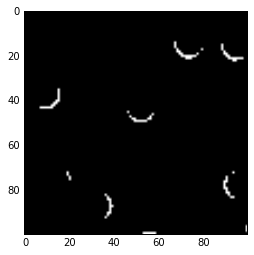

In [180]:
plt.imshow(img1)

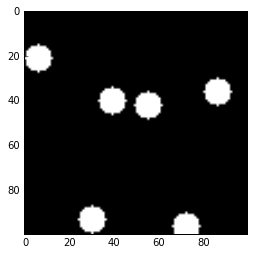

In [75]:
plt.imshow(img2)

In [181]:
c_1, labels_1, stats_1, centroids_1 = cv2.connectedComponentsWithStats(img1, 4)
c_2, labels_2, stats_2, centroids_2 = cv2.connectedComponentsWithStats(img2, 4)

In [182]:
centroids_1

array([[ 49.39191102,  49.47997978],
       [ 71.15789474,  18.84210526],
       [ 91.64705882,  19.70588235],
       [ 79.        ,  17.        ],
       [ 12.52941176,  40.52941176],
       [ 46.        ,  45.        ],
       [ 52.07692308,  48.15384615],
       [ 19.5       ,  73.5       ],
       [ 93.        ,  72.        ],
       [ 90.21428571,  78.85714286],
       [ 37.5       ,  87.        ],
       [ 99.        ,  97.        ],
       [ 55.5       ,  99.        ]])

In [82]:
centroids_2

array([[ 49.64985544,  49.21779634],
       [  6.        ,  21.        ],
       [ 86.        ,  36.        ],
       [ 39.        ,  40.        ],
       [ 55.        ,  42.        ],
       [ 30.        ,  93.        ],
       [ 72.        ,  95.19791667]])

In [84]:
darr = np.zeros((c_1 - 1, c_2 - 1))

In [93]:
from scipy.spatial.distance import cdist

In [94]:
y = cdist(centroids_1, centroids_2, 'sqeuclidean')

In [96]:
y.shape

(8L, 7L)

In [98]:
np.argmin(y, 1)

array([0, 1, 2, 3, 4, 5, 5, 6], dtype=int64)

In [99]:
y = np.sqrt(y)
y

array([[  0.70996093,  52.19708625,  38.00981568,  14.22228161,
          8.29758551,  48.62627893,  51.29430428],
       [ 51.97647459,   0.        ,  81.39410298,  38.07886553,
         53.31041174,  75.89466384,  99.30423373],
       [ 36.80546931,  79.42921377,   2.        ,  45.17742799,
         29.61418579,  78.51751397,  60.40193157],
       [ 13.45182507,  38.58756276,  47.26520919,   1.        ,
         16.03121954,  52.77309921,  63.45403195],
       [  6.79331703,  53.22593353,  32.984845  ,  15.5241747 ,
          2.23606798,  54.56189146,  54.26994261],
       [ 55.19553573,  62.        ,  92.78469701,  54.20332093,
         63.89053138,  26.        ,  67.11772621],
       [ 47.58884812,  76.21679605,  79.20858539,  53.60037313,
         56.36488268,   1.        ,  41.05887039],
       [ 51.5693777 ,  99.97165017,  60.60852529,  64.82908301,
         56.16064759,  43.05613589,   1.        ]])

In [103]:
np.amin(y, axis = 0)

array([ 0.70996093,  0.        ,  2.        ,  1.        ,  2.23606798,
        1.        ,  1.        ])

In [104]:
np.amin(y, axis = 1)

array([  0.70996093,   0.        ,   2.        ,   1.        ,
         2.23606798,  26.        ,   1.        ,   1.        ])

In [108]:

for p in range(0, len(centroids_1)):
    if min(y[p]) < 9: # if newest center is lesser than 9 pixels 
        # adjust center to 6 pixels in direction
        # add to global map
    else: # must be a new blob
        # add to global map
        print p, min(y[p])

0 0.709960932178
1 0.0
2 2.0
3 1.0
4 2.2360679775
6 1.0
7 1.0


In [109]:
def drawObstacle(img, (x, y), r, value):
    cv2.circle(img, (int(x), int(y)), r, (value), -1)
    return img

In [207]:
from scipy.spatial.distance import cdist
import math
def getNewCenter(l_x, l_y, g_x, g_y):
    newX = 0
    newY = 0
    d = -((np.sqrt((l_x-g_x)**2 + (l_y-g_y)**2)) - 6)
    
    if (g_x == l_x and g_y == l_y):
        return (g_x-4, g_y-4)
    if (g_x == l_x):
        if (l_y > g_y):
            #move down
            newY = g_y + d
            newX = g_x
        elif (l_y < g_y):
            #move down
            newY = g_y - d
            newX = g_x
            
    elif (g_y == l_y):
        if (l_x > g_x):
            #move down
            newY = g_y
            newX = g_x + d
        elif (l_x < g_x):
            #move down
            newY = g_y
            newX = g_x - d
    else:
        theta = math.atan( (l_y - g_y) / (l_x - g_x) )
        newX = g_x - (d * math.cos(theta))
        newY = g_y - (d * math.sin(theta))
        print l_x, l_y, g_x, g_y, newX, newY
    return (newX, newY)

def remap(local_map, global_map):
    c_l, labels_l, stats_l, centroids_l = cv2.connectedComponentsWithStats(local_map, 4)
    c_g, labels_g, stats_g, centroids_g = cv2.connectedComponentsWithStats(global_map, 4)
    
    #get distance matrix between all centroids
    dist = cdist(centroids_l, centroids_g, 'sqeuclidean')
    
    #find shortes distance between the local and global obstacle positions
    
    for p in range(1, c_l):
        if min(dist[p]) < 9: # if newest center is lesser than 9 pixels 
            # adjust center to 6 pixels in direction
            best_g = np.argmin(dist[p])
            (cx, cy) = getNewCenter(centroids_l[p][0], centroids_l[p][1], centroids_g[best_g][0], centroids_g[best_g][1])
            global_map = drawObstacle(global_map, (cx, cy), 6, 255)
            # add to global map
        else: # must be a new blob
            global_map = drawObstacle(global_map, (centroids_l[p][0], centroids_l[p][1]), 6, 255)
    plt.imshow(global_map)
    

In [142]:
img1 = cv2.imread('F:/Dispatch/OccGrid/37global_map.png', 0)
img2 = cv2.imread('F:/Dispatch/OccGrid/38global_map.png', 0)
img3 = cv2.imread('F:/Dispatch/OccGrid/38global_map.png', 0)

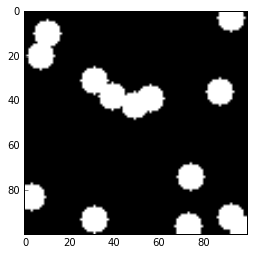

In [143]:
remap(img1, img2)

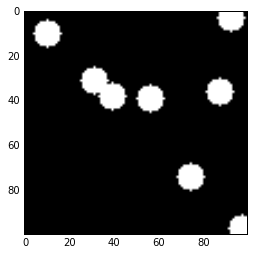

In [144]:
plt.imshow(img3)

In [183]:
getNewCenter(46, 45, 45, 47)

46 45 45 47 43.316718427 50.366563146


(43.316718427000254, 50.366563145999493)

In [203]:
getNewCenter(45, 98, 44, 96)#42.946844203 99.7362234297

45 98 44 96 45.683281573 99.366563146


(45.683281572999746, 99.366563145999493)

In [208]:
getNewCenter(58, 49, 56.0, 49.0,)# 52.0 49.0)

(60.0, 49.0)

### 

In [209]:
A = np.zeros((2,2))
A[0, 0] = 0.99
A[0, 1] = 0.01
A[1, 0] = 0.01
A[1, 1] = 0.99

In [210]:
A

array([[ 0.99,  0.01],
       [ 0.01,  0.99]])

In [219]:
p = np.zeros((1,2))
p[0, 0] = 0.7
p[0,1] = 0.3
p

array([[ 0.7,  0.3]])

In [220]:
p.dot(A)

array([[ 0.696,  0.304]])

In [221]:
p.shape

(1L, 2L)

In [222]:
p[0, 0]/ (p[0, 0] + p[0, 1])

0.69999999999999996